In [17]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np
import matplotlib
%matplotlib inline
import seaborn as sns
import missingno as msno
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [18]:
!pip install missingno

### 결측치 점검

In [ ]:
df_raw = pd.read_csv("C:\\Users\\user\\Desktop\\0822_H_data.csv")

df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14956 entries, 0 to 14955
Columns: 254 entries, id to hm_01_rel_t
dtypes: float64(178), int64(74), object(2)
memory usage: 29.0+ MB


In [20]:
df = df_raw.drop(['emp_keep_a', 'hazard_phy_d','hazard_phy_a','hazard_phy_c','hazard_phy_e','hazard_phy_f','hazard_phy_g','hazard_phy_h', 'hazard_phy_i', 'ch_downsizing', 'job_c1_r', 'job_c1', 'emp_pay_type', 'skillmat', 'emp_comp_com_a','emp_comp_com_b','emp_comp_com_c','ch_ic','ch_restruct','wplace_sl','emp_noncon', 'wcomback'], axis = 1)

In [21]:
# 널값 개수와 비율 계산
null_summary = (
    df.isnull().sum()
      .to_frame("널값 개수")
      .assign(널값비율 = lambda x: (x["널값 개수"] / len(df_raw) * 100).round(2))
      .reset_index()
      .rename(columns={'index': '컬럼명'})
)

# 널값 있는 열만 필터링 & 비율 기준 내림차순 정렬
null_summary = (
    null_summary[null_summary["널값 개수"] > 0]
    .sort_values(by="널값비율", ascending=False)
    .reset_index(drop=True)
)

print(null_summary)

                  컬럼명  널값 개수  널값비율
0         comp_size_b    870  5.82
1        wtime_ftwork    584  3.90
2            emp_keep    581  3.88
3          emo_manual    307  2.05
4    wtime_resilience    279  1.87
..                ...    ...   ...
150       wsituation7      2  0.01
151      wsituation13      1  0.01
152            wstat1      1  0.01
153         winten2_a      2  0.01
154     wtime_length3      2  0.01

[155 rows x 3 columns]


In [22]:
# start 파일
# df.to_csv("2PD_v1_0822.csv", encoding="CP949")

### 중복 피쳐 삭제/8,9->결측치 수정

In [23]:
# 불필요한 피쳐 삭제하기 (14개)
df = df.drop(columns=["ptime_r", "stratification", "district", "household", "target", "mode", "hh_num", "eli_num", "hm_01_gender", "hm_01_year", "hm_01_estat", "hm_01_rel_t","wtime_week", "earning1_r"])

print(df)

              id burnout60  area  gender  age  wduration_y  earning1  \
0      1000042_1       lv1     1       1   49           10       500   
1      1000051_1       lv2     1       1   31            2       300   
2      1000056_1       lv1     1       1   32            2       300   
3      1000069_1       lv1     1       1   38            2       390   
4      1000069_2       lv1     1       2   37            5       330   
...          ...       ...   ...     ...  ...          ...       ...   
14951  2010124_1       lv1     7       1   37            6       450   
14952  2010133_1       lv2     7       2   46            3       230   
14953  2010134_2       lv1     7       2   34            5       320   
14954  2010137_1       lv1     7       1   57            5       450   
14955  2010137_2       lv1     7       2   29            3       350   

       earning2_r  wtime_r  woutside4_a  ...  edu  marital  children  \
0               6     40.0            1  ...  5.0      1.0     

In [24]:
# 전처리: 8, 9 NULL (5개)
cols = ["hazard_erg_a", "hazard_erg_b", "hazard_erg_c", "hazard_erg_d", "hazard_erg_e"]

df[cols] = df[cols].replace([8, 9], pd.NA)

print(df['hazard_erg_a'].unique())
print(df['hazard_erg_b'].unique())
print(df['hazard_erg_c'].unique())
print(df['hazard_erg_d'].unique())
print(df['hazard_erg_e'].unique())


[6 2 1 7 5 4 3 <NA>]
[1 5 6 3 4 7 2 <NA>]
[ 7.  6.  2.  5.  4.  3.  1. nan]
[ 7.  2.  5.  4.  6.  3. nan  1.]
[ 7.  3.  5.  6.  4.  2.  1. nan]


In [25]:
# 잘못 변경된 변수명 복원
df.rename(columns={
    "wsituation": "wsituation8",
    "wsituation.1": "wsituation9",
    "disc": "disc9",
    "disc.1": "disc8"
}, inplace=True)

### 긍/부정 변경

In [26]:
df["wstat4"].head(10) 

0    2
1    2
2    2
3    3
4    5
5    5
6    5
7    5
8    5
9    5
Name: wstat4, dtype: int64

In [27]:
# 긍/부정 변경
# 5점 척도

cols = [
    "wstat4", "wstat6",
    "wwa1", "wwa2", "wwa3", "wwa4", "wwa5",
    "sleep1", "sleep2", "sleep3",
    "imte1", "imte2", "imte3", "imte4", "imte5",
    "wsituation12", "wsituation14"
]

# 변환 딕셔너리 (5점 척도 역코딩)
reverse_map = {1: 5, 2: 4, 3: 3, 4: 2, 5: 1}

# 여러 열에 적용
for col in cols:
    df[col] = df[col].map(reverse_map).fillna(df[col])

df["wstat4"].head(10) 

0    4
1    4
2    4
3    3
4    1
5    1
6    1
7    1
8    1
9    1
Name: wstat4, dtype: int64

In [28]:
# 3점 척도 
cols_2 = [
   "heal_lim1"
]

# 변환 딕셔너리 (3점 척도 역코딩)
reverse_map = {1: 3, 2: 2, 3: 1}

# 여러 열에 적용
for col in cols_2:
    df[col] = df[col].map(reverse_map).fillna(df[col])


#%%
print(df.columns.tolist())
#%%
print(df[cols_2].head())
#%%
df["heal_lim1"].head(10) 
#%%


['id', 'burnout60', 'area', 'gender', 'age', 'wduration_y', 'earning1', 'earning2_r', 'wtime_r', 'woutside4_a', 'wtime_length5', 'age_group', 'emp_period_group', 'wtime_group', 'compsize_group', 'woutside_group', 'compsize_group_a', 'wday_week_group_a', 'woutside4_group_a', 'occ_t2_group_a', 'earning2_group_b', 'occ_group_a', 'emp_stat', 'emp_con_term', 'emp_keep', 'emp_own_mgmt', 'emp_fptime', 'emp_wage', 'emp_stat_sp', 'income_pos_a', 'income_pos_b', 'income_pos_c', 'income_pos_d', 'income_pos_e', 'income_pos_f', 'income_pos_g', 'income_pos_h', 'income_pos_i', 'income_pos_j', 'emp_place', 'emp_suggest_a', 'emp_suggest_b', 'emp_boss_gender', 'emp_manaqual_a', 'emp_manaqual_b', 'emp_manaqual_c', 'emp_manaqual_d', 'emp_manaqual_e', 'emp_comp_ass_a', 'emp_comp_ass_b', 'emp_comp_ass_c', 'emp_comp_ass_d', 'emp_comp_ass_e', 'emp_comp_ass_f', 'emp_rep', 'emp_winflu_a', 'emp_winflu_b', 'emp_winflu_c', 'emp_tra_b', 'emp_tra_c', 'emp_tra_d', 'wsector', 'comp_size_a', 'comp_size_b', 'comp_female

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
5    1.0
6    1.0
7    1.0
8    1.0
9    1.0
Name: heal_lim1, dtype: float64

In [29]:
# 4점 척도
cols_1 = [
    "imte1", "imte2", "imte3", "imte4", "imte5",
]

# 변환 딕셔너리 (4점 척도 역코딩)
reverse_map = {1: 4, 2: 3, 3: 2, 4: 1}

# 여러 열에 적용
for col in cols_1:
    df[col] = df[col].map(reverse_map).fillna(df[col])


#%%
print(df.columns.tolist())
#%%
print(df[cols_1].head())
#%%
df["imte1"].head(10) 
#%%

['id', 'burnout60', 'area', 'gender', 'age', 'wduration_y', 'earning1', 'earning2_r', 'wtime_r', 'woutside4_a', 'wtime_length5', 'age_group', 'emp_period_group', 'wtime_group', 'compsize_group', 'woutside_group', 'compsize_group_a', 'wday_week_group_a', 'woutside4_group_a', 'occ_t2_group_a', 'earning2_group_b', 'occ_group_a', 'emp_stat', 'emp_con_term', 'emp_keep', 'emp_own_mgmt', 'emp_fptime', 'emp_wage', 'emp_stat_sp', 'income_pos_a', 'income_pos_b', 'income_pos_c', 'income_pos_d', 'income_pos_e', 'income_pos_f', 'income_pos_g', 'income_pos_h', 'income_pos_i', 'income_pos_j', 'emp_place', 'emp_suggest_a', 'emp_suggest_b', 'emp_boss_gender', 'emp_manaqual_a', 'emp_manaqual_b', 'emp_manaqual_c', 'emp_manaqual_d', 'emp_manaqual_e', 'emp_comp_ass_a', 'emp_comp_ass_b', 'emp_comp_ass_c', 'emp_comp_ass_d', 'emp_comp_ass_e', 'emp_comp_ass_f', 'emp_rep', 'emp_winflu_a', 'emp_winflu_b', 'emp_winflu_c', 'emp_tra_b', 'emp_tra_c', 'emp_tra_d', 'wsector', 'comp_size_a', 'comp_size_b', 'comp_female

0    1.0
1    1.0
2    1.0
3    3.0
4    2.0
5    2.0
6    2.0
7    1.0
8    2.0
9    2.0
Name: imte1, dtype: float64

### 연속형 변수 재범주화

In [30]:
df['heal_abs1'].value_counts()

heal_abs1
0.0      14127
2.0        181
1.0        127
3.0        113
5.0         80
7.0         65
10.0        31
8.0         25
4.0         24
6.0         10
15.0         9
20.0         6
30.0         6
14.0         5
13.0         5
12.0         4
90.0         3
60.0         2
11.0         1
180.0        1
120.0        1
50.0         1
21.0         1
Name: count, dtype: int64

In [31]:
# 범주화 

df["heal_abs1_group"] = np.where(df["heal_abs1"] == 0, 0, 1)
df['heal_abs1_group'] = df['heal_abs1_group'].map({0: 1, 1: 2})
#%%
print(df["heal_abs1_group"].head())
#%%
df["heal_abs1_group"].value_counts()


0    1
1    1
2    1
3    1
4    1
Name: heal_abs1_group, dtype: int64


heal_abs1_group
1    14127
2      829
Name: count, dtype: int64

In [32]:
# 구간 (0~60, 61~120, 121 이상)
bins = [0, 60, 120, float("inf")]
labels = [1, 2, 3]

df["ctime_group"] = pd.cut(df["ctime"], bins=bins, labels=labels, right=True)
#%%
print(df["ctime_group"].head())
#%%
df["ctime_group"].value_counts()
#%%

0      1
1      1
2      1
3      2
4    NaN
Name: ctime_group, dtype: category
Categories (3, int64): [1 < 2 < 3]


ctime_group
1    12582
2     1150
3      328
Name: count, dtype: int64

In [33]:
# 파생변수로 대체된 컬럼 삭제
df = df.drop(['heal_abs1','ctime'], axis = 1)
print(df)

              id burnout60  area  gender  age  wduration_y  earning1  \
0      1000042_1       lv1     1       1   49           10       500   
1      1000051_1       lv2     1       1   31            2       300   
2      1000056_1       lv1     1       1   32            2       300   
3      1000069_1       lv1     1       1   38            2       390   
4      1000069_2       lv1     1       2   37            5       330   
...          ...       ...   ...     ...  ...          ...       ...   
14951  2010124_1       lv1     7       1   37            6       450   
14952  2010133_1       lv2     7       2   46            3       230   
14953  2010134_2       lv1     7       2   34            5       320   
14954  2010137_1       lv1     7       1   57            5       450   
14955  2010137_2       lv1     7       2   29            3       350   

       earning2_r  wtime_r  woutside4_a  ...  children  panel_survey  ind  \
0               6     40.0            1  ...       1.0    

### 중복 피쳐 삭제

In [34]:
# 1차 프로젝트에서 파생변수 만들었던 변수 삭제
df = df.drop(['occ', 'occ2', 'age', 'earning2_r', 'wday_week', 'woutside4', 'wtime_r', 'wduration_y'], axis = 1)

### 상관관계 매트릭스 분석

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

corr = df.corr(numeric_only=True)
# sns.heatmap(corr, cmap="coolwarm", center=0)
# plt.show()

In [36]:
# 상관계수 절댓값이 0.8 이상인 쌍만 추출 (자기 자신 제외)
high_corr = (
    corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))  
        .stack()                                               
        .reset_index()
        .rename(columns={'level_0': '변수1', 'level_1': '변수2', 0: '상관계수'})
)

# 조건 필터링
high_corr = high_corr[high_corr['상관계수'].abs() >= 0.8]

print(high_corr.sort_values(by='상관계수', ascending=False).head(20))

                    변수1           변수2      상관계수
10060       comp_size_b  comp_sizeb_r  1.000000
10059       comp_size_b  comp_sizea_r  1.000000
15552             disc3         disc4  0.988628
20492               ind          ind2  0.985571
15452             disc2         disc3  0.984493
15453             disc2         disc4  0.982562
1780     compsize_group  comp_sizeb_r  0.975227
1636     compsize_group   comp_size_b  0.969841
15351             disc8         disc2  0.962101
15353             disc8         disc4  0.956305
15352             disc8         disc3  0.954483
15249             disc7         disc8  0.944109
15250             disc7         disc2  0.920967
20499      comp_sizea_r  comp_sizeb_r  0.920086
2165   compsize_group_a  comp_sizeb_r  0.916659
15252             disc7         disc4  0.913893
15251             disc7         disc3  0.913422
1779     compsize_group  comp_sizea_r  0.910546
2021   compsize_group_a   comp_size_b  0.893071
15146             disc6         disc7  0

In [37]:
unique_vars = set(high_corr['변수1']).union(set(high_corr['변수2']))
print("조건 충족하는 변수 개수:", len(unique_vars))
print("변수 목록:", unique_vars)

조건 충족하는 변수 개수: 23
변수 목록: {'disc8', 'ind2', 'comp_size_b', 'compsize_group', 'disc6', 'compsize_group_a', 'winten2_a', 'winten2_b', 'woutside4_a', 'disc7', 'winten3_d', 'disc2', 'earning2_group_b', 'decla_b', 'disc4', 'earning1', 'woutside_group', 'ind', 'comp_sizea_r', 'comp_sizeb_r', 'winten3_c', 'decla_a', 'disc3'}


In [38]:
# 상관분석 결과 필요없는 변수 삭제
df = df.drop(['comp_size_b', 'comp_sizea_r', 'comp_sizeb_r', 'ind', 'ind2', 'earning1', 'woutside4_a'], axis = 1)

In [39]:
# disc 변수 : 차별 유/무로 파생변수 생성
cols = ['disc1','disc2','disc3','disc4','disc5',
        'disc6','disc7','disc8','disc9','disc10','disc11']

# 하나라도 1이 있으면 1, 아니면 0
df['disc_group'] = (df[cols].sum(axis=1) > 0).astype(int)

df['disc_group'] = df['disc_group'].map({0: 1, 1: 2})

print(df['disc_group'].unique())

[2 1]


In [40]:
# decla 변수 : 작업선택의 가능성 유/무로 파생변수 생성
cols = ['decla_a','decla_b']

# 하나라도 1이 있으면 1, 아니면 0
df['decla_group'] = (df[cols].sum(axis=1) > 0).astype(int)

df['decla_group'] = df['decla_group'].map({0: 1, 1: 2})

print(df['decla_group'].unique())

[2 1]


In [41]:
# winten2 변수 : 작업 강도가 세다로 파생변수 생성(7점 척도)
cols = ['winten2_a','winten2_b']

# 둘 중 하나라도 있으면 최대값
df['winten2_group'] = df[cols].max(axis=1, skipna=True)

print(df['winten2_group'].unique())

[ 5.  6.  7.  1.  4.  3.  2. nan]


In [42]:
# winten3 변수 : 작업선택의 가능성 유/무로 파생변수 생성
cols = ['winten3_c','winten3_d', 'winten3_a', 'winten3_b', 'winten3_e']

# 하나라도 1이 있으면 1, 아니면 0
df['winten3_group'] = (df[cols].sum(axis=1) > 0).astype(int)

df['winten3_group'] = df['winten3_group'].map({0: 1, 1: 2})

print(df['winten3_group'].unique())

[2 1]


In [43]:
# 파생변수로 대체된 컬럼 삭제
df = df.drop(['disc1','disc2','disc3','disc4','disc5',
              'disc6','disc7','disc8','disc9','disc10','disc11','decla_a','decla_b','winten2_a','winten2_b', 'winten3_c','winten3_d', 'winten3_a', 'winten3_b', 'winten3_e'], axis = 1)

### 조작적 정의에 사용된 변수 삭제

In [44]:
df = df.drop(['weng1','weng2','weng3','wsituation14','wwa2','sleep2','sleep3','weng4','weng5','wsituation1','wstat4','wsituation2','wsituation12', 'wsituation10','wsituation9'], axis = 1)

### 널값 삭제

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14956 entries, 0 to 14955
Columns: 172 entries, id to winten3_group
dtypes: category(1), float64(133), int64(34), object(4)
memory usage: 19.5+ MB


In [46]:
df_new = df.dropna()

In [47]:
df_new

,id,burnout60,area,gender,wtime_length5,age_group,emp_period_group,wtime_group,compsize_group,woutside_group,...,edu,marital,children,panel_survey,heal_abs1_group,ctime_group,disc_group,decla_group,winten2_group,winten3_group
0,1000042_1,lv1,1,1,2,4,5,2,4,0,...,5.0,1.0,1.0,2,1,1,2,2,5.0,2
1,1000051_1,lv2,1,1,2,3,2,2,11,0,...,6.0,2.0,2.0,2,1,1,2,2,6.0,2
2,1000056_1,lv1,1,1,2,3,2,2,1,0,...,5.0,2.0,2.0,2,1,1,2,2,5.0,2
3,1000069_1,lv1,1,1,2,3,2,2,10,0,...,6.0,1.0,1.0,2,1,2,2,2,7.0,2
5,1000077_1,lv1,1,1,2,3,2,2,10,0,...,6.0,1.0,2.0,2,1,1,2,2,6.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14949,2009922_1,lv1,13,1,1,3,5,2,12,1,...,6.0,2.0,2.0,2,1,1,2,2,4.0,2
14952,2010133_1,lv2,7,2,2,4,3,2,4,0,...,5.0,2.0,2.0,2,1,1,2,2,4.0,2
14953,2010134_2,lv1,7,2,2,3,4,2,4,0,...,6.0,2.0,2.0,2,1,1,2,2,5.0,2
14954,2010137_1,lv1,7,1,2,5,4,2,4,0,...,6.0,1.0,1.0,2,1,1,2,2,5.0,2


### AutoML

In [48]:
df_new['burnout60'].unique()

array(['lv1', 'lv2', 'lv3'], dtype=object)

In [49]:
# 타겟 클래스번호 전처리
df_new['burnout60'] = df_new['burnout60'].replace("lv1", 1)
df_new['burnout60'] = df_new['burnout60'].replace("lv2", 2)
df_new['burnout60'] = df_new['burnout60'].replace("lv3", 3)
df_new['burnout60'].unique()

C:\Users\user\AppData\Local\Temp\ipykernel_10308\1668657739.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['burnout60'] = df_new['burnout60'].replace("lv1", 1)
C:\Users\user\AppData\Local\Temp\ipykernel_10308\1668657739.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['burnout60'] = df_new['burnout60'].replace("lv2", 2)
C:\Users\user\AppData\Local\Temp\ipykernel_10308\1668657739.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

array([1, 2, 3], dtype=int64)

In [50]:
df_new['burnout60'] = df_new['burnout60'].astype('category')
print(df_new["burnout60"])

0        1
1        2
2        1
3        1
5        1
        ..
14949    1
14952    2
14953    1
14954    1
14955    1
Name: burnout60, Length: 11243, dtype: category
Categories (3, int64): [1, 2, 3]


C:\Users\user\AppData\Local\Temp\ipykernel_10308\2922573805.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['burnout60'] = df_new['burnout60'].astype('category')


In [51]:
# categories.values

In [52]:
categories = df_new.drop(columns=['id', 'burnout60']).columns

In [53]:
categories = categories.tolist()

In [54]:
from pycaret.classification import *
from sklearn.preprocessing import *
# import imblearn
setup_clf = setup(df_new, target = 'burnout60',
                  train_size = 0.8,
                  # ignore_features = ['pclass', 'adult_male', 'deck', 'embark_town', 'alive'],
                  # numeric_features = [],
                  categorical_features = categories,
                  # encoding_method = None,
                #   normalize = True,
                #   normalize_method = 'zscore',
                  # remove_outliers = True,
                #   feature_selection = True,
                  # feature_selection_method = 'classic',
                  # fix_imbalance = True,
                  # fix_imbalance_method = 'SMOTE',
                  fold=5,
                  n_jobs = - 1,
                  session_id = 1234)

,Description,Value
0,Session id,1234
1,Target,burnout60
2,Target type,Multiclass
3,Target mapping,"1: 0, 2: 1, 3: 2"
4,Original data shape,"(11243, 172)"
5,Transformed data shape,"(11243, 554)"
6,Transformed train set shape,"(8994, 554)"
7,Transformed test set shape,"(2249, 554)"
8,Categorical features,170
9,Preprocess,True


In [55]:
X_train_transformed = get_config('X_train_transformed')
print(X_train_transformed)

              id  area_15.0  area_9.0  area_1.0  area_2.0  area_5.0  \
13039  1263166_1        1.0       0.0       0.0       0.0       0.0   
8216   1146807_1        0.0       1.0       0.0       0.0       0.0   
1529   1025402_2        0.0       0.0       1.0       0.0       0.0   
1971   1034083_1        0.0       0.0       1.0       0.0       0.0   
2748   1046201_1        0.0       0.0       0.0       1.0       0.0   
...          ...        ...       ...       ...       ...       ...   
12863  1254489_1        0.0       0.0       0.0       0.0       0.0   
6917   1125201_1        0.0       0.0       0.0       0.0       0.0   
5985   1103941_1        0.0       0.0       0.0       0.0       1.0   
12451  1243720_1        0.0       0.0       0.0       0.0       0.0   
10791  1192682_1        0.0       0.0       0.0       0.0       0.0   

       area_10.0  area_12.0  area_3.0  area_17.0  ...  disc_group  \
13039        0.0        0.0       0.0        0.0  ...         1.0   
8216     

In [56]:
best = compare_models(fold=10, sort='AUC')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.8765,0.8756,0.8765,0.8526,0.8551,0.3722,0.4011,3.0640
rf,Random Forest Classifier,0.8618,0.8593,0.8618,0.8082,0.8105,0.1301,0.2104,1.0730
et,Extra Trees Classifier,0.8635,0.8578,0.8635,0.8139,0.8163,0.1642,0.2390,1.4310
knn,K Neighbors Classifier,0.8418,0.6810,0.8418,0.7901,0.8060,0.1281,0.1501,1.6820
dt,Decision Tree Classifier,0.7982,0.6335,0.7982,0.8054,0.8016,0.2258,0.2262,1.2130
dummy,Dummy Classifier,0.8553,0.5000,0.8553,0.7316,0.7887,0.0000,0.0000,1.1370
ada,Ada Boost Classifier,0.8696,0.0000,0.8696,0.8407,0.8469,0.3377,0.3649,1.9980
gbc,Gradient Boosting Classifier,0.8766,0.0000,0.8766,0.8501,0.8532,0.3612,0.3956,2.8520


In [57]:
!pip install lightgbm

In [58]:
import lightgbm as lgb
print(lgb.__version__)

4.6.0


In [59]:
lgbm_model = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8777,0.8913,0.8777,0.8523,0.8556,0.3720,0.4045
1,0.8733,0.8789,0.8733,0.8491,0.8522,0.3626,0.3875
2,0.8733,0.8416,0.8733,0.8463,0.8471,0.3246,0.3651
3,0.8766,0.8849,0.8766,0.8529,0.8565,0.3853,0.4103
4,0.8710,0.8739,0.8710,0.8470,0.8525,0.3679,0.3872
Mean,0.8744,0.8741,0.8744,0.8495,0.8528,0.3625,0.3909
Std,0.0025,0.0173,0.0025,0.0027,0.0033,0.0204,0.0158


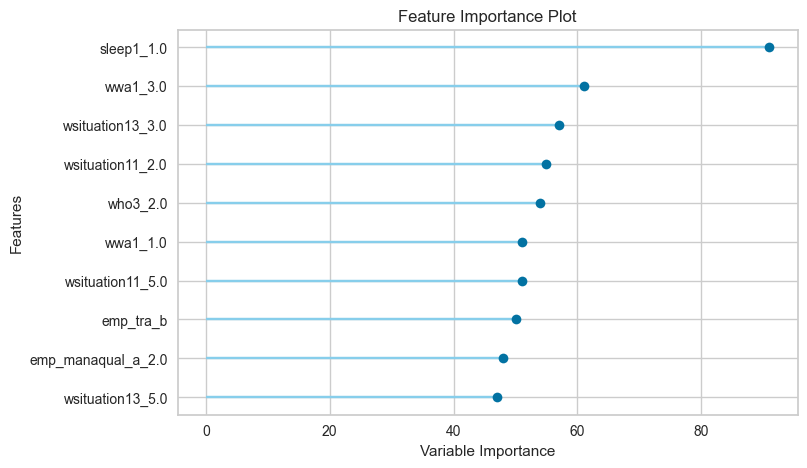

In [60]:
plot_model(lgbm_model, plot='feature')

In [65]:
 df_new.head()

,id,burnout60,area,gender,wtime_length5,age_group,emp_period_group,wtime_group,compsize_group,woutside_group,...,edu,marital,children,panel_survey,heal_abs1_group,ctime_group,disc_group,decla_group,winten2_group,winten3_group
0,1000042_1,1,1,1,2,4,5,2,4,0,...,5.0,1.0,1.0,2,1,1,2,2,5.0,2
1,1000051_1,2,1,1,2,3,2,2,11,0,...,6.0,2.0,2.0,2,1,1,2,2,6.0,2
2,1000056_1,1,1,1,2,3,2,2,1,0,...,5.0,2.0,2.0,2,1,1,2,2,5.0,2
3,1000069_1,1,1,1,2,3,2,2,10,0,...,6.0,1.0,1.0,2,1,2,2,2,7.0,2
5,1000077_1,1,1,1,2,3,2,2,10,0,...,6.0,1.0,2.0,2,1,1,2,2,6.0,2


In [69]:
from sklearn.model_selection import cross_validate
from lightgbm import LGBMClassifier
lgb = LGBMClassifier(random_state=42)


In [142]:
### Feature Selection - Embedded 방식 ###

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
import numpy as np

# 식별자 컬럼은 제거
X_ = X_train.drop(columns=['id'], errors='ignore')

num_cols = X_.select_dtypes(include=[np.number, 'bool']).columns
cat_cols = X_.select_dtypes(include=['object']).columns

preprocess = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols),
    ]
)

clf = Pipeline(steps=[
    ('pre', preprocess),
    ('model', LGBMClassifier(random_state=42))
])

scores = cross_validate(clf, X_, y_train, cv=10, n_jobs=-1, return_train_score=True)
print(scores)


{'fit_time': array([2.8380599 , 2.86925435, 2.84607816, 3.30367136, 3.31078434,
       2.84116483, 2.89284682, 2.85656953, 2.99327254, 2.88282275]), 'score_time': array([0.02608514, 0.02268887, 0.02207589, 0.02052927, 0.02203631,
       0.01741147, 0.03947997, 0.02687526, 0.02865362, 0.03533387]), 'test_score': array([0.86444444, 0.89      , 0.86222222, 0.88333333, 0.86651835,
       0.88431591, 0.88320356, 0.87541713, 0.88209121, 0.88542825]), 'train_score': array([0.98702743, 0.98702743, 0.98727452, 0.98789227, 0.98987029,
       0.98752316, 0.98912909, 0.98863496, 0.98838789, 0.9869055 ])}


In [143]:
### object 컬럼 확인
obj_cols = X.select_dtypes(include=["object"]).columns.tolist()
print("Object columns:", obj_cols)

Object columns: []


In [145]:
# 교차검증 실행 (이미 실행했다면 생략)
scores = cross_validate(clf, X_, y_train, cv=10, n_jobs=-1, return_train_score=True)

# 평균/표준편차 정리
summary = {
    "train_score_mean": np.mean(scores['train_score']),
    "train_score_std": np.std(scores['train_score']),
    "test_score_mean": np.mean(scores['test_score']),
    "test_score_std": np.std(scores['test_score']),
}

# 보기 좋게 DataFrame으로 변환
summary_df = pd.DataFrame([summary])
print(summary_df)


   train_score_mean  train_score_std  test_score_mean  test_score_std
0          0.987967         0.000958         0.877697        0.009389


In [144]:
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
import lightgbm as lgb

# feature/target 분리
X = df_new.drop("burnout60", axis=1)   # 입력 변수
y = df_new["burnout60"]                # 타깃 변수

# train/val 분리 (한 번만 실행)
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# LightGBM 모델 설정 및 학습
lgbm = lgb.LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    random_state=42
)
lgbm.fit(X_train, y_train)

# Embedded Feature Selection
selector = SelectFromModel(lgbm, threshold="mean", prefit=True)
X_train_selected = selector.transform(X_train)
X_val_selected = selector.transform(X_val)

print("Original feature number:", X_train.shape[1])
print("Selected feature number:", X_train_selected.shape[1])

# 선택된 feature 이름 출력
selected_features = X.columns[selector.get_support()]
print("Selected features:", selected_features.tolist())


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000969 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 767
[LightGBM] [Info] Number of data points in the train set: 8994, number of used features: 162
[LightGBM] [Info] Start training from score -0.161329
[LightGBM] [Info] Start training from score -2.049000
[LightGBM] [Info] Start training from score -3.905816
Original feature number: 171
Selected feature number: 70
Selected features: ['area', 'age_group', 'emp_period_group', 'compsize_group', 'woutside4_group_a', 'earning2_group_b', 'occ_group_a', 'emp_manaqual_a', 'emp_manaqual_b', 'emp_manaqual_c', 'emp_manaqual_d', 'emp_manaqual_e', 'emp_comp_ass_b', 'emp_comp_ass_c', 'emp_comp_ass_d', 'emp_comp_ass_e', 'emp_comp_ass_f', 'emp_winflu_a', 'emp_winflu_b', 'emp_winflu_c', 'comp_female', 'comp_sjob', 'imte1', 'imte2', 'imte3', 'imte4', 'i

In [146]:
# 1) Baseline: 전체 특성으로 학습
from sklearn.metrics import accuracy_score, precision_score

lgbm.fit(X_train, y_train)

y_pred_base = lgbm.predict(X_val)

acc_base = accuracy_score(y_val, y_pred_base)
prec_base = precision_score(y_val, y_pred_base, average="weighted")  # 다중분류면 "weighted"

print("=== Baseline (모든 특성) ===")
print(f"Accuracy : {acc_base:.4f}")
print(f"Precision: {prec_base:.4f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001122 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 767
[LightGBM] [Info] Number of data points in the train set: 8994, number of used features: 162
[LightGBM] [Info] Start training from score -0.161329
[LightGBM] [Info] Start training from score -2.049000
[LightGBM] [Info] Start training from score -3.905816
=== Baseline (모든 특성) ===
Accuracy : 0.8844
Precision: 0.8650


In [147]:
# 2) Embedded Feature Selection
selected_mask = selector.get_support()
selected_cols = X.columns[selected_mask].tolist()

X_train_sel_df = X_train[selected_cols].copy()
X_val_sel_df   = X_val[selected_cols].copy()

print(f"\n선택된 특성 개수: {len(selected_cols)} / {X_train.shape[1]}")
print("선택된 특성 리스트:", selected_cols)


선택된 특성 개수: 70 / 171
선택된 특성 리스트: ['area', 'age_group', 'emp_period_group', 'compsize_group', 'woutside4_group_a', 'earning2_group_b', 'occ_group_a', 'emp_manaqual_a', 'emp_manaqual_b', 'emp_manaqual_c', 'emp_manaqual_d', 'emp_manaqual_e', 'emp_comp_ass_b', 'emp_comp_ass_c', 'emp_comp_ass_d', 'emp_comp_ass_e', 'emp_comp_ass_f', 'emp_winflu_a', 'emp_winflu_b', 'emp_winflu_c', 'comp_female', 'comp_sjob', 'imte1', 'imte2', 'imte3', 'imte4', 'imte5', 'safeinform', 'wsituation3', 'wsituation4', 'wsituation5', 'wsituation11', 'wsituation6', 'wsituation7', 'wsituation8', 'wsituation13', 'wstat1', 'wstat2', 'wstat3', 'wstat5', 'wstat6', 'wstat7', 'wtime_ftwork', 'wtime_ftcomtool', 'wtime_private', 'hazard_phy_b', 'hazard_erg_a', 'hazard_erg_b', 'hazard_erg_c', 'hazard_erg_d', 'hazard_erg_e', 'winterrupt1', 'satisfaction', 'wpalce_ch', 'wwa1', 'wwa3', 'wwa4', 'wwa5', 'heal_cond', 'sleep1', 'who1', 'who2', 'who3', 'who4', 'who5', 'woutside3', 'income_con', 'income_bal', 'edu', 'winten2_group']


In [148]:
# 3) 선택된 특성으로 재학습
sel_model = lgb.LGBMClassifier(
    n_estimators=500,
    learning_rate=0.05,
    random_state=42
)
sel_model.fit(X_train_sel_df, y_train)

y_pred_sel = sel_model.predict(X_val_sel_df)

acc_sel = accuracy_score(y_val, y_pred_sel)
prec_sel = precision_score(y_val, y_pred_sel, average="weighted")

print("\n=== Selected Features (임베디드 선택) ===")
print(f"Accuracy : {acc_sel:.4f}")
print(f"Precision: {prec_sel:.4f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000294 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 458
[LightGBM] [Info] Number of data points in the train set: 8994, number of used features: 70
[LightGBM] [Info] Start training from score -0.161329
[LightGBM] [Info] Start training from score -2.049000
[LightGBM] [Info] Start training from score -3.905816

=== Selected Features (임베디드 선택) ===
Accuracy : 0.8853
Precision: 0.8626


In [161]:
# 4) 성능 비교 표
summary = pd.DataFrame({
    "metric": ["Accuracy", "Precision"],
    "All features": [acc_base, prec_base],
    "Selected features": [acc_sel, prec_sel]
})
print("\n=== 성능 비교 ===")
print(summary)



=== 성능 비교 ===
      metric  All features  Selected features
0   Accuracy      0.884393           0.885282
1  Precision      0.865023           0.862611


In [164]:
### 시각화
# 1) 중요도 테이블 만들기 (선택됨/제외됨 표시)

# 학습된 모델의 중요도 정리 (LightGBM의 전체 특성 중요도)
imp_df = pd.DataFrame({
    "feature": X.columns,
    "importance": lgbm.feature_importances_.astype(float)
}).sort_values("importance", ascending=False)

# 선택 여부 컬럼 추가
support_mask = selector.get_support()
imp_df["selected"] = imp_df["feature"].isin(X.columns[support_mask])

# 중요도 정규화(퍼센트)
imp_df["importance_pct"] = 100 * imp_df["importance"] / (imp_df["importance"].sum() + 1e-12)

imp_df.head(10)


,feature,importance,selected,importance_pct
1,area,1141.0,True,2.535556
70,wsituation11,829.0,True,1.842222
73,wsituation8,824.0,True,1.831111
36,emp_manaqual_a,781.0,True,1.735556
74,wsituation13,698.0,True,1.551111
130,wwa1,666.0,True,1.480000
78,wstat5,662.0,True,1.471111
14,occ_group_a,658.0,True,1.462222
50,emp_winflu_c,650.0,True,1.444444
49,emp_winflu_b,641.0,True,1.424444


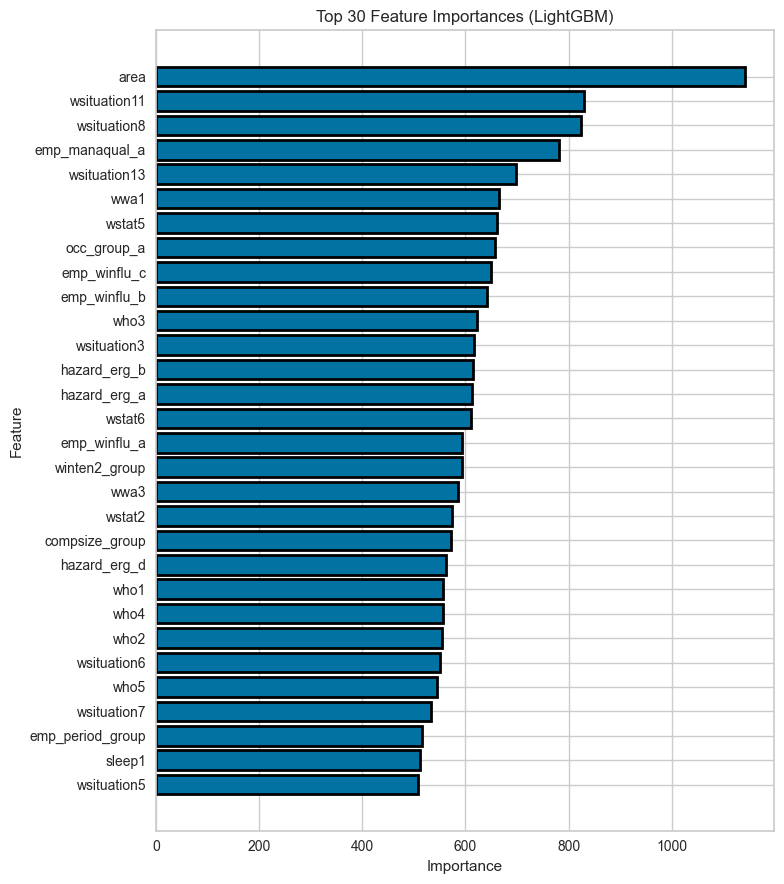

In [165]:
# 2) 상위 N개 중요도 막대 그래프 (선택된 특성 하이라이트)

import matplotlib.pyplot as plt

N = 30  # 상위 몇 개를 볼지
top = imp_df.head(N).iloc[::-1]  # barh는 뒤집어 주면 보기 좋아짐

plt.figure(figsize=(8, max(6, N*0.3)))
bars = plt.barh(top["feature"], top["importance"])

# 선택된 특성은 두께/외곽선으로 하이라이트
for i, sel in enumerate(top["selected"]):
    if sel:
        bars[i].set_linewidth(2.0)
        bars[i].set_edgecolor("black")  # matplotlib 기본 팔레트 내 색 사용
    else:
        bars[i].set_alpha(0.5)

plt.title(f"Top {N} Feature Importances (LightGBM)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


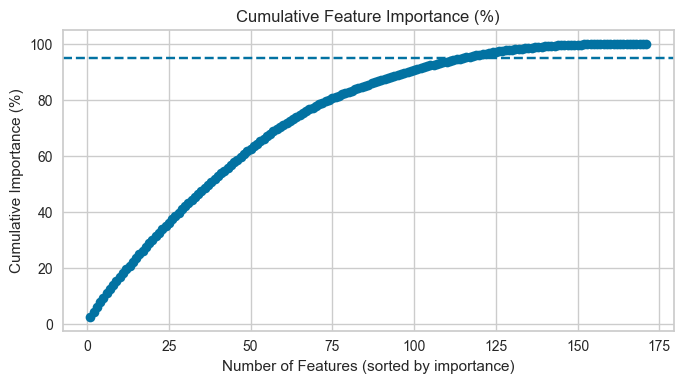

In [166]:
# 3) 누적 중요도 그래프 (얼마나 줄여도 되는지 감 잡기)

cum = imp_df.copy()
cum["cum_importance_pct"] = cum["importance_pct"].cumsum()

plt.figure(figsize=(7,4))
plt.plot(np.arange(1, len(cum)+1), cum["cum_importance_pct"], marker="o")
plt.axhline(95, linestyle="--")  # 95% 선
plt.title("Cumulative Feature Importance (%)")
plt.xlabel("Number of Features (sorted by importance)")
plt.ylabel("Cumulative Importance (%)")
plt.tight_layout()
plt.show()


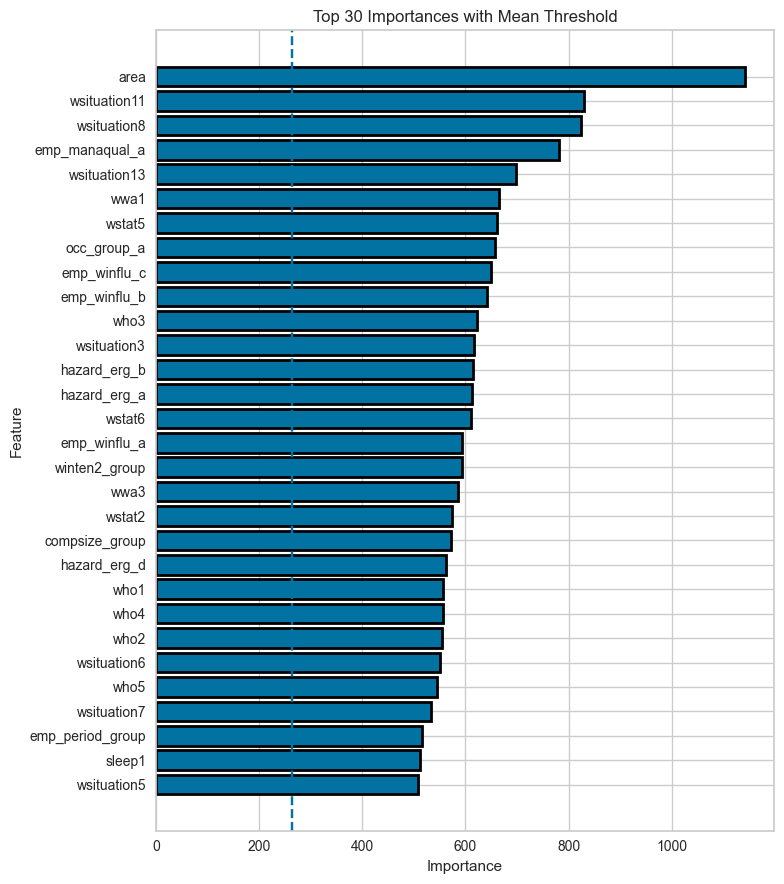

In [167]:
# 4) 선택 임계값(평균 중요도)과의 비교 시각화

thresh = imp_df["importance"].mean()

plt.figure(figsize=(8, max(6, N*0.3)))
top = imp_df.head(N).iloc[::-1]
bars = plt.barh(top["feature"], top["importance"])

# 평균선
plt.axvline(thresh, linestyle="--")

# 선택된 특성 강조
for i, sel in enumerate(top["selected"]):
    if sel:
        bars[i].set_linewidth(2.0)
        bars[i].set_edgecolor("black")
    else:
        bars[i].set_alpha(0.5)

plt.title(f"Top {N} Importances with Mean Threshold")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


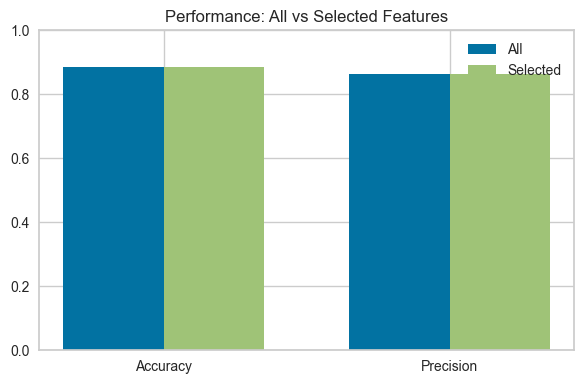

In [168]:
# 5) 선택 전/후 성능 및 특성 수 비교(요약 바차트)

# 이미 이전 단계에서 계산했을 것으로 가정:
# acc_base, prec_base, acc_sel, prec_sel

labels = ["Accuracy", "Precision"]
all_features_scores = [acc_base, prec_base]
selected_features_scores = [acc_sel, prec_sel]

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(6,4))
plt.bar(x - width/2, all_features_scores, width, label="All")
plt.bar(x + width/2, selected_features_scores, width, label="Selected")
plt.xticks(x, labels)
plt.ylim(0, 1.0)
plt.title("Performance: All vs Selected Features")
plt.legend()
plt.tight_layout()
plt.show()


In [170]:
# 선택된 특성만 따로 보기 (표/리스트)

selected_only = imp_df[imp_df["selected"]].copy().sort_values("importance", ascending=False)
print("선택된 특성 개수:", selected_only.shape[0])
selected_only.head(20)


선택된 특성 개수: 70


,feature,importance,selected,importance_pct
1,area,1141.0,True,2.535556
70,wsituation11,829.0,True,1.842222
73,wsituation8,824.0,True,1.831111
36,emp_manaqual_a,781.0,True,1.735556
74,wsituation13,698.0,True,1.551111
130,wwa1,666.0,True,1.480000
78,wstat5,662.0,True,1.471111
14,occ_group_a,658.0,True,1.462222
50,emp_winflu_c,650.0,True,1.444444
49,emp_winflu_b,641.0,True,1.424444


In [171]:
!pip install shap


In [172]:

# 설명할 데이터 (선택된 특성만)
X_val_used = X_val[selected_cols].copy()

# LightGBM용 TreeExplainer
explainer = shap.TreeExplainer(sel_model)

# 큰 데이터면 샘플링(속도/가독성)
N = min(2000, len(X_val_used))
idx = np.random.RandomState(42).choice(len(X_val_used), N, replace=False)
X_val_sample = X_val_used.iloc[idx]

# SHAP 값 계산
# (경고 억제를 원하면 check_additivity=False 사용 가능)
shap_values = explainer.shap_values(X_val_sample)


In [173]:
# 다중/이진 자동 분기
is_multiclass = isinstance(shap_values, list)

if is_multiclass:
    # 클래스별 SHAP 배열을 쓴다. (예: 평균 절댓값 최대 클래스, 또는 특정 클래스 선택)
    # 1) 평균 절댓값이 가장 큰 클래스를 대표로 시각화 (전반적 경향 확인용)
    mean_abs = [np.abs(v).mean() for v in shap_values]
    target_class = int(np.argmax(mean_abs))
    sv_for_plot = shap_values[target_class]
    class_info = f"(multi-class, class={target_class})"
else:
    sv_for_plot = shap_values
    class_info = "(binary)"


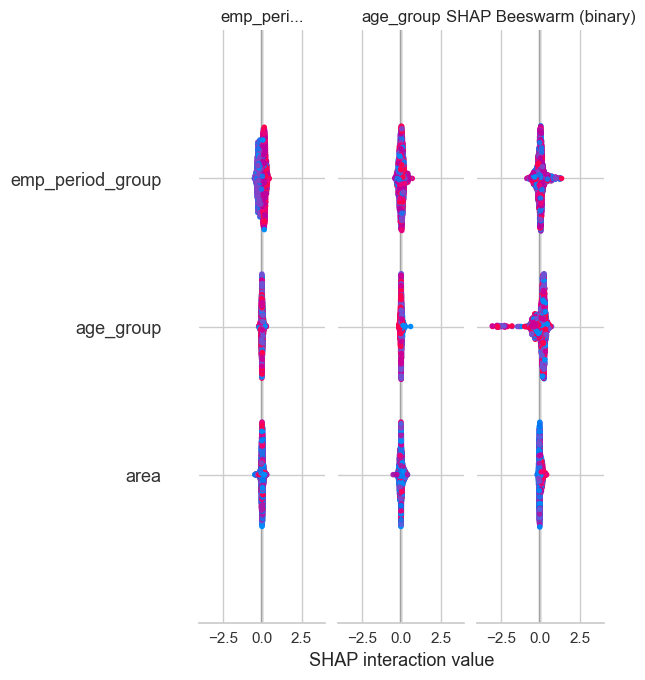

In [174]:
# Beeswarm (개별 샘플 분포 + 영향)

shap.summary_plot(sv_for_plot, X_val_sample, show=False)
import matplotlib.pyplot as plt
plt.title(f"SHAP Beeswarm {class_info}")
plt.show()


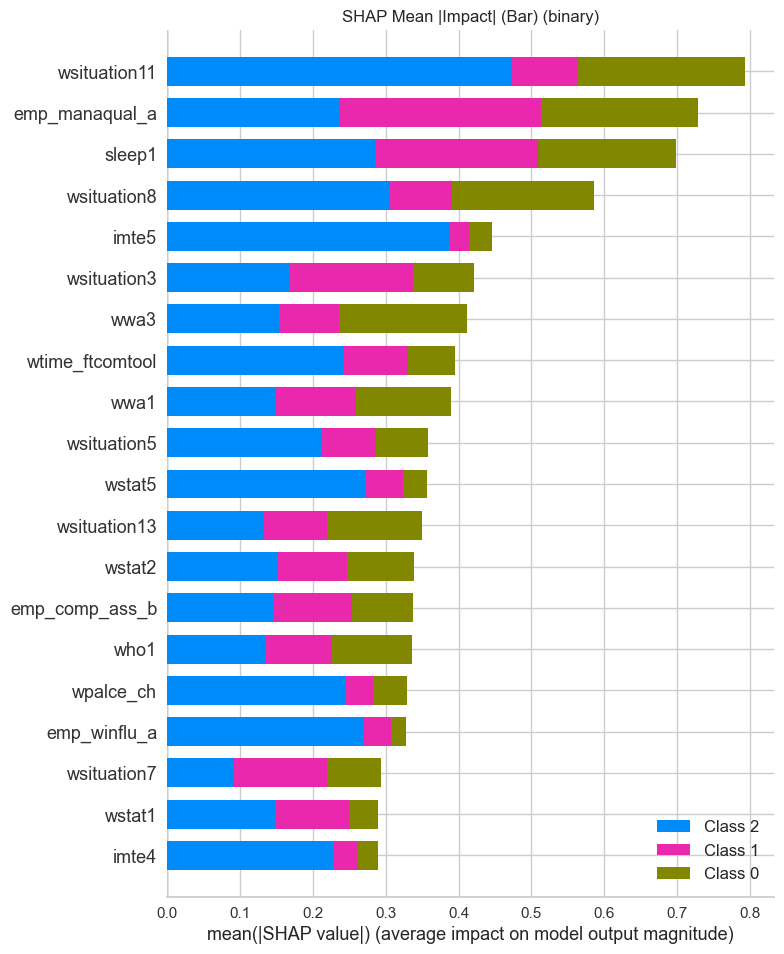

In [101]:
# Bar (평균 절댓값 중요도)

shap.summary_plot(sv_for_plot, X_val_sample, plot_type="bar", show=False)
import matplotlib.pyplot as plt
plt.title(f"SHAP Mean |Impact| (Bar) {class_info}")
plt.show()


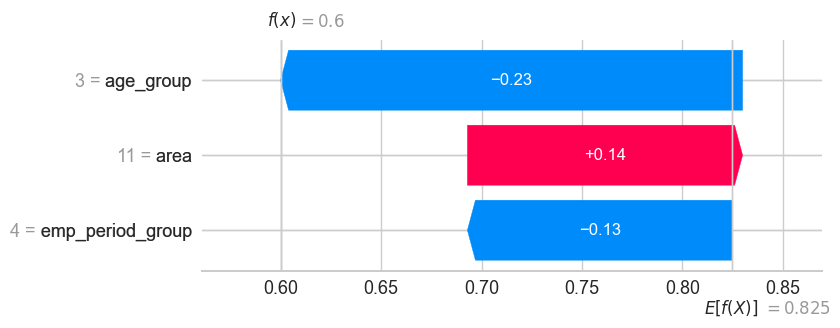

In [107]:
# 하나의 인스턴스 Waterfall 

i = 0              # 샘플 인덱스
target_class = 0   # 분석할 클래스 인덱스 지정

ex = shap.Explanation(
    values = shap_values[target_class][i],           # 선택 클래스의 shap 값
    base_values = explainer.expected_value[target_class], # 선택 클래스의 expected value (스칼라)
    data = X_val_sample.iloc[i],
    feature_names = X_val_sample.columns
)

shap.plots.waterfall(ex, max_display=20)


In [ ]:
### feature selection + shap

import shap
import re
from scipy import sparse

In [137]:
# 함수 호출 전에 딱 2줄만 추가
import numpy as np, pandas as pd
X_train = X_train.replace({pd.NA: np.nan})  # NAType → np.nan


In [136]:
def build_preprocess(X):
    num_cols = X.select_dtypes(include=[np.number, 'bool']).columns.tolist()
    cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
    pre = ColumnTransformer(
        transformers=[
            ('num', 'passthrough', num_cols),
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_cols),
        ]
    )
    return pre, num_cols, cat_cols

def get_feature_names(pre, num_cols, cat_cols):
    # ColumnTransformer + OneHotEncoder의 출력 이름
    # scikit-learn 1.0+ 에서 제공
    names = []
    # 숫자 특성: 'num__col'
    names += [f'num__{c}' for c in num_cols]
    # 범주 특성: 'cat__원본특성=카테고리'
    if len(cat_cols) > 0:
        ohe = pre.named_transformers_['cat']
        ohe_names = ohe.get_feature_names_out(cat_cols).tolist()
        names += [f'cat__{n}' for n in ohe_names]
    return np.array(names)

def _to_dense(X_mat):
    if sparse.issparse(X_mat):
        return X_mat.toarray()
    return X_mat

def _mean_abs_shap_values(explainer, X_mat):
    # shap_values는 버전에 따라 모양이 다름:
    # - 바이너리: (n_samples, n_features)
    # - 멀티클래스: (n_classes, n_samples, n_features) 또는 (n_samples, n_features, n_classes)
    sv = explainer(X_mat, check_additivity=False).values
    if sv is None:
        # 구버전 API 호환
        sv = explainer.shap_values(X_mat)
    sv = np.asarray(sv)

    if sv.ndim == 2:
        # (n_samples, n_features)
        return np.mean(np.abs(sv), axis=0)
    elif sv.ndim == 3:
        # (n_classes, n_samples, n_features) OR (n_samples, n_features, n_classes)
        # 두 경우를 모두 커버
        if sv.shape[0] < 10 and sv.shape[0] != X_mat.shape[0]:
            # (n_classes, n_samples, n_features) 로 가정
            sv_abs = np.abs(sv)  # (C, N, F)
            sv_abs = sv_abs.mean(axis=1)  # (C, F)
            return sv_abs.mean(axis=0)    # (F,)
        else:
            # (n_samples, n_features, n_classes)
            sv_abs = np.abs(sv).mean(axis=2)  # (N, F)
            return sv_abs.mean(axis=0)        # (F,)
    else:
        raise ValueError(f"Unexpected SHAP shape: {sv.shape}")

def _group_to_original_cols(feature_names, importances):
    """
    OHE된 'cat__col=value'들을 원본 'col' 기준으로 합산.
    또한 'num__col'은 그대로 사용.
    """
    base_names = []
    for name in feature_names:
        # 패턴: 'num__col' 또는 'cat__원본=값'
        m = re.match(r'^(?:num|cat)__(.*)$', name)
        inner = m.group(1) if m else name
        # OHE면 '원본=값' → '원본'으로 축약
        if '=' in inner:
            base_names.append(inner.split('=')[0])
        else:
            base_names.append(inner)
    df = pd.DataFrame({'feature_expanded': feature_names,
                       'base_feature': base_names,
                       'importance': importances})
    grouped = df.groupby('base_feature', as_index=False)['importance'].sum()
    grouped.sort_values('importance', ascending=False, inplace=True)
    grouped['rank'] = np.arange(1, len(grouped)+1)
    return grouped[['base_feature', 'importance', 'rank']]

def shap_feature_selection(
    X, y,
    model=None,
    preprocess=None,
    n_splits=5,
    random_state=42,
    top_k=30,
    group_ohe=True
):
    """
    반환:
      - df_importance_expanded: OHE 포함(확장) 피처 중요도
      - df_importance_grouped: 원본 피처 기준 집계 중요도 (group_ohe=True일 때)
      - selected_features: 최종 선택된 top_k 피처 리스트 (원본 피처 기준)
    """
    if model is None:
        model = LGBMClassifier(random_state=random_state)

    if preprocess is None:
        preprocess, num_cols, cat_cols = build_preprocess(X)
    else:
        # 가능하면 자동 추출 시도
        try:
            num_cols = preprocess.transformers_[0][2]
            cat_cols = preprocess.transformers_[1][2]
        except Exception:
            num_cols = X.select_dtypes(include=[np.number, 'bool']).columns.tolist()
            cat_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    # 확장 피처 이름/중요도 누적
    expanded_names_global = None
    expanded_importance_sum = None

    for fold, (tr_idx, va_idx) in enumerate(skf.split(X, y), 1):
        X_tr, y_tr = X.iloc[tr_idx], y.iloc[tr_idx]
        X_va, y_va = X.iloc[va_idx], y.iloc[va_idx]

        # 전처리 학습 & 변환
        preprocess_fitted = preprocess.fit(X_tr)
        X_tr_t = _to_dense(preprocess_fitted.transform(X_tr))
        X_va_t = _to_dense(preprocess_fitted.transform(X_va))

        # 확장 피처 이름
        feat_names = get_feature_names(preprocess_fitted, num_cols, cat_cols)
        if expanded_names_global is None:
            expanded_names_global = feat_names

        # 모델 학습 (전처리 결과에 직접 학습)
        clf = LGBMClassifier(random_state=random_state)
        clf.fit(X_tr_t, y_tr)

        # SHAP 설명자
        explainer = shap.TreeExplainer(clf, feature_perturbation="tree_path_dependent")
        imp_fold = _mean_abs_shap_values(explainer, X_va_t)  # (n_features,)

        # 길이 체크 (SHAP-이름 불일치 방지)
        if len(imp_fold) != len(feat_names):
            raise ValueError(f"Mismatch: SHAP features={len(imp_fold)} vs names={len(feat_names)}")

        if expanded_importance_sum is None:
            expanded_importance_sum = np.zeros_like(imp_fold, dtype=float)
        expanded_importance_sum += imp_fold

    # 폴드 평균
    expanded_importance_mean = expanded_importance_sum / n_splits
    df_importance_expanded = pd.DataFrame({
        'feature_expanded': expanded_names_global,
        'importance': expanded_importance_mean
    }).sort_values('importance', ascending=False, ignore_index=True)
    df_importance_expanded['rank'] = df_importance_expanded.index + 1

    if group_ohe:
        df_importance_grouped = _group_to_original_cols(
            df_importance_expanded['feature_expanded'].values,
            df_importance_expanded['importance'].values
        )
        selected_features = df_importance_grouped.head(top_k)['base_feature'].tolist()
        return df_importance_expanded, df_importance_grouped, selected_features
    else:
        selected_features = df_importance_expanded.head(top_k)['feature_expanded'].tolist()
        return df_importance_expanded, None, selected_features

# ================================
# 사용 예시
# ================================
# X_train, y_train 이 준비되어 있다고 가정
# 전처리 자동 구성 + LGBM + 5-Fold CV로 SHAP 기반 중요도 집계
# OHE는 원본 피처로 묶어서(top_k=30) 선택
# df_expanded: OHE 확장 피처별 중요도 / df_grouped: 원본 피처별 중요도
# selected: 최종 선택 피처(원본 기준)
# df_grouped를 보고 top_k 조정하면 됨.

# preprocess, _, _ = build_preprocess(X_train)  # (선택) 직접 만들고 싶으면
# model = LGBMClassifier(random_state=42)       # (선택) 하이퍼파라미터 설정 가능

df_expanded, df_grouped, selected = shap_feature_selection(
    X_train, y_train,
    model=None,
    preprocess=None,
    n_splits=5,
    random_state=42,
    top_k=30,
    group_ohe=True
)

print("▶ 확장 피처 상위 10개")
print(df_expanded.head(10))
print("\n▶ 원본 피처(묶음) 상위 10개")
print(df_grouped.head(10))
print("\n▶ 최종 선택 피처 목록 (top_k):")
print(selected)


TypeError: float() argument must be a string or a real number, not 'NAType'